<a href="https://colab.research.google.com/github/Saivignesh0904/Rain_Predictor_ML/blob/main/rain_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)

import joblib

# display settings
pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = (8, 5)

In [23]:
# Load the Dataset
# ===============

# Change this path if your CSV has a different name or location
data_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"  # or "weatherAUS.csv"

df = pd.read_csv(data_path)

# Ensure the target column is clean immediately after loading
target_col = "RainTomorrow"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset. "
                     "Please verify your CSV has this column.")
df = df.dropna(subset=[target_col])

print("Shape of raw data after dropping missing target:", df.shape)
df.head()


Shape of raw data after dropping missing target: (142193, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# Basic Info & Summary
# =========================

print("\nData types and non-null counts:")
df.info()

print("\nSummary statistics (numeric columns):")
display(df.describe().T)


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


In [4]:
# Missing Values Summary
# =========================

missing_counts = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent.round(2)
})

print("Missing values per column:")
missing_df


Missing values per column:


,missing_count,missing_percent
Sunshine,69835,48.01
Evaporation,62790,43.17
Cloud3pm,59358,40.81
Cloud9am,55888,38.42
Pressure9am,15065,10.36
Pressure3pm,15028,10.33
WindDir9am,10566,7.26
WindGustDir,10326,7.10
WindGustSpeed,10263,7.06
Humidity3pm,4507,3.10


In [5]:
# Remove Duplicates
# =========================

before_dups = df.shape[0]
df = df.drop_duplicates()
after_dups = df.shape[0]

print(f"Removed {before_dups - after_dups} duplicate rows.")
print("New shape:", df.shape)

Removed 0 duplicate rows.
New shape: (145460, 23)


In [6]:
# Convert Date to datetime
# =========================

if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    # Extract useful date features
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day

In [24]:
# This cell is now redundant as target NaNs are handled during loading
# To avoid confusion, the functionality is moved to the data loading cell.
# The `df` should already be cleaned of missing `RainTomorrow` values.

# target_col = "RainTomorrow"  # predicting if it will rain tomorrow

# if target_col not in df.columns:
#     raise ValueError(f"Target column '{target_col}' not found in dataset. "
#                      "Please verify your CSV has this column.")

# before_target_na = df.shape[0]
# df = df.dropna(subset=[target_col])
# after_target_na = df.shape[0]

# print(f"Dropped {before_target_na - after_target_na} rows with missing target.")
# print("Shape after dropping missing target:", df.shape)


In [8]:
# Outlier Handling (IQR)
# =========================

# We will cap extreme outliers for selected continuous variables
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

def cap_outliers_iqr(data, cols, factor=1.5):
    data = data.copy()
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            continue
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    return data

df = cap_outliers_iqr(df, numeric_cols)
print("Outliers capped for numeric columns (IQR method).")


Outliers capped for numeric columns (IQR method).


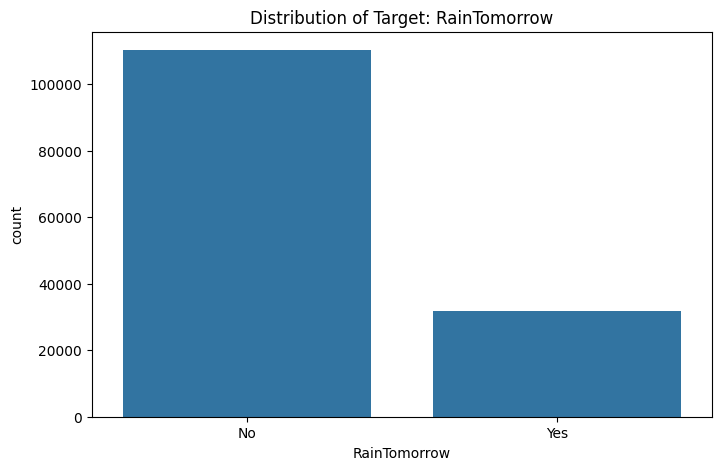

RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64


In [9]:
# EDA 1: Target Distribution
# =========================

sns.countplot(x=target_col, data=df)
plt.title("Distribution of Target: RainTomorrow")
plt.show()

print(df[target_col].value_counts(normalize=True).rename("proportion"))

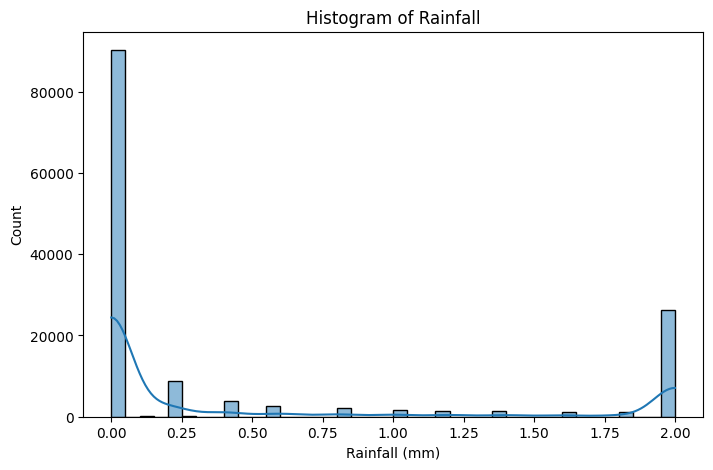

In [11]:
 #EDA 2: Histogram of Rainfall
# =========================

if "Rainfall" in df.columns:
    sns.histplot(df["Rainfall"].dropna(), bins=40, kde=True)
    plt.title("Histogram of Rainfall")
    plt.xlabel("Rainfall (mm)")
    plt.show()

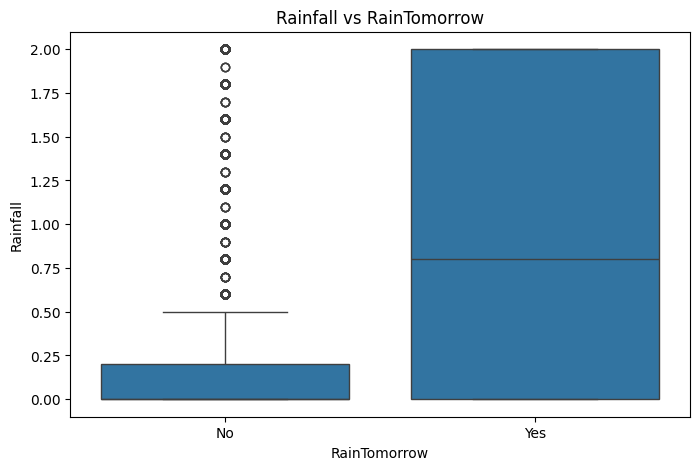

In [12]:
# EDA 3: Boxplot - Rainfall vs RainTomorrow
# =========================

if "Rainfall" in df.columns:
    sns.boxplot(x=target_col, y="Rainfall", data=df)
    plt.title("Rainfall vs RainTomorrow")
    plt.show()

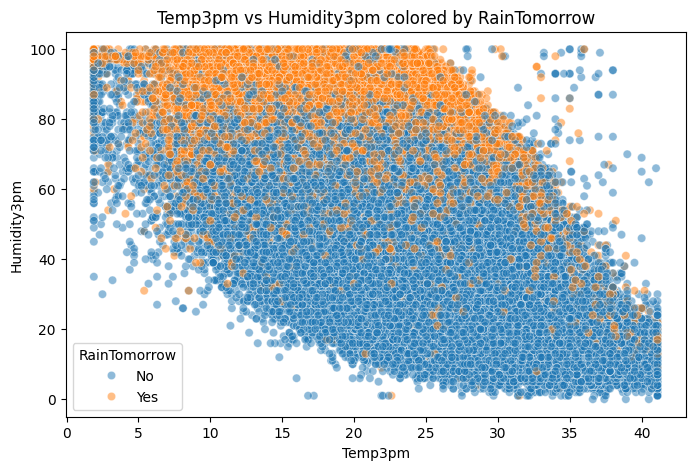

In [13]:
# =========================
# EDA 4: Scatter - Temp vs Humidity (3pm)
# =========================

if {"Temp3pm", "Humidity3pm"}.issubset(df.columns):
    sns.scatterplot(x="Temp3pm", y="Humidity3pm", hue=target_col, data=df, alpha=0.5)
    plt.title("Temp3pm vs Humidity3pm colored by RainTomorrow")
    plt.show()

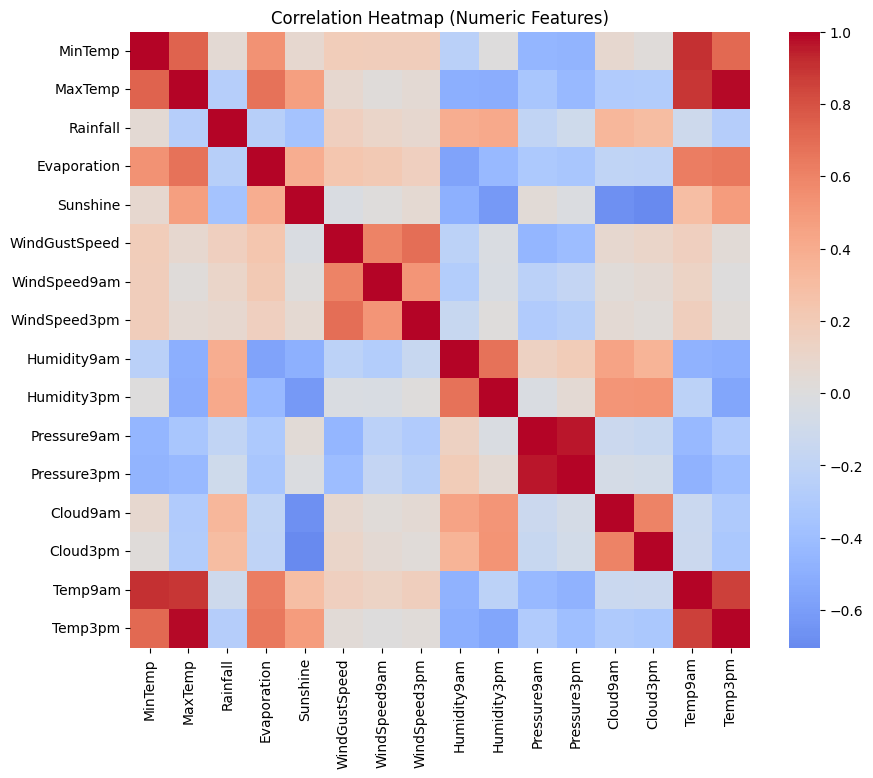

In [14]:
# EDA 5: Correlation Heatmap
# =========================

corr_matrix = df.select_dtypes(include=["int64", "float64"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

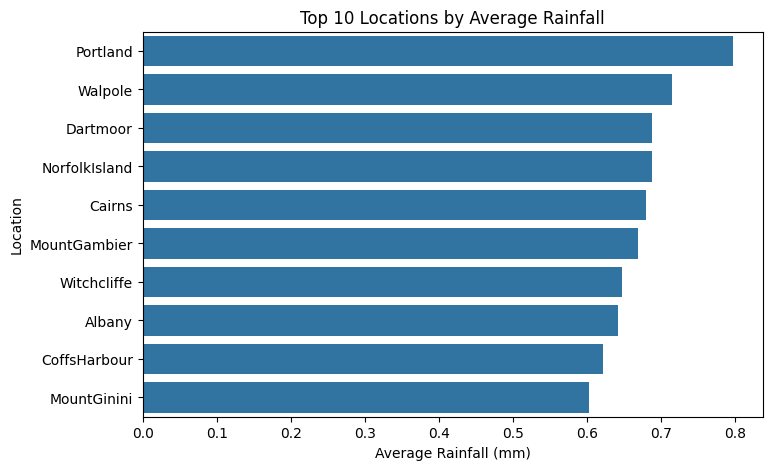

In [15]:
# EDA 6: Average Rainfall by Location (Top 10)
# =========================

if {"Location", "Rainfall"}.issubset(df.columns):
    loc_rainfall = (df.groupby("Location")["Rainfall"]
                      .mean()
                      .sort_values(ascending=False)
                      .head(10))
    sns.barplot(x=loc_rainfall.values, y=loc_rainfall.index)
    plt.xlabel("Average Rainfall (mm)")
    plt.ylabel("Location")
    plt.title("Top 10 Locations by Average Rainfall")
    plt.show()

In [21]:
if {"MaxTemp", "MinTemp"}.issubset(df.columns):
    df["TempRange"] = df["MaxTemp"] - df["MinTemp"]

if {"Humidity3pm", "Humidity9am"}.issubset(df.columns):
    df["HumidityDiff"] = df["Humidity3pm"] - df["Humidity9am"]

# =========================
# Binning Rainfall into Categories
# =========================

if "Rainfall" in df.columns:
    current_max_rainfall = df["Rainfall"].max()

    # Define base bins and labels
    dynamic_bins = [-0.01, 0.0]
    dynamic_labels = ["NoRain"]

    # Add 'Low' boundary and label if max rainfall suggests it's relevant
    if current_max_rainfall > 0.0:
        # If max rainfall is between 0 and 10, the upper bound of 'Low' should be max_rainfall
        if current_max_rainfall <= 10.0:
            dynamic_bins.append(current_max_rainfall + 0.01) # Extend to max_rainfall
        else:
            dynamic_bins.append(10.0)
        dynamic_labels.append("Low")

    # Add 'Moderate' boundary and label if max rainfall suggests it's relevant
    if current_max_rainfall > 10.0:
        # If max rainfall is between 10 and 30, the upper bound of 'Moderate' should be max_rainfall
        if current_max_rainfall <= 30.0:
            dynamic_bins.append(current_max_rainfall + 0.01)
        else:
            dynamic_bins.append(30.0)
        dynamic_labels.append("Moderate")

    # Add 'High' label and ensure the last bin covers the maximum value
    if current_max_rainfall > 30.0:
        # Ensure the last bin extends slightly beyond the max_rainfall_value
        dynamic_bins.append(current_max_rainfall + 0.01)
        dynamic_labels.append("High")

    # Ensure bins are strictly increasing and unique (though the logic above should handle this)
    # It's good practice to sort and unique if constructing complex dynamic bins
    dynamic_bins = sorted(list(set(dynamic_bins)))

    # Ensure the number of labels matches the number of bins minus one
    # If max_rainfall was capped low, we might not need all labels
    if len(dynamic_labels) != len(dynamic_bins) - 1:
        # This handles cases where categories like 'Moderate' or 'High' are not applicable
        # due to low max_rainfall_value, so we only use the labels that correspond to the actual bins.
        # The construction logic ensures dynamic_labels grows with dynamic_bins.
        # So, it should be fine as long as dynamic_bins is monotonic.
        pass # The logic above ensures correct # of labels vs bins

    df["RainfallBin"] = pd.cut(
        df["Rainfall"],
        bins=dynamic_bins,
        labels=dynamic_labels,
        right=True # Default, but explicit for clarity
    )

df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,TempRange,HumidityDiff,RainfallBin
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,NaN,2008,12,1,9.5,-49.0,Low
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,NaN,2008,12,2,17.7,-19.0,NoRain
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,NaN,2008,12,3,12.8,-8.0,NoRain
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,NaN,2008,12,4,18.8,-29.0,NoRain
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,NaN,2008,12,5,14.8,-49.0,Low


In [31]:
# Train/Test Split
# =========================

# Ensure no NaN values in the target column before splitting
df_clean = df.dropna(subset=[target_col])

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (113754, 22)
Test shape: (28439, 22)


In [26]:
# Identify Numeric & Categorical Columns
# =========================

numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("\nCategorical features:", categorical_features)


Numeric features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

Categorical features: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [28]:
# Preprocessing Pipelines
# =========================

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [29]:
# Define Models
# =========================

log_reg_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

models = {
    "Logistic Regression": log_reg_clf,
    "Random Forest": rf_clf
}


In [32]:
# Model Training & Evaluation
# =========================

results = []

for name, model in models.items():
    print(f"\n===== Training {name} ===telek")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # some models provide predict_proba (needed for ROC-AUC)
    if hasattr(model, "predict_proba"):
        # Ensure y_proba corresponds to the 'Yes' class
        y_proba = model.predict_proba(X_test)[:, model.classes_.tolist().index('Yes')]
        roc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc = np.nan

    acc = accuracy_score(y_test, y_pred)
    # Explicitly set pos_label for string targets
    prec = precision_score(y_test, y_pred, pos_label='Yes', zero_division=0)
    rec = recall_score(y_test, y_pred, pos_label='Yes', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='Yes', zero_division=0)

    results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc
    })

results_df = pd.DataFrame(results).set_index("model")
print("\n=== Model Performance ===")
results_df



===== Training Logistic Regression ===telek

===== Training Random Forest ===telek

=== Model Performance ===


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Logistic Regression,0.856008,0.737203,0.555765,0.633754,0.884741
Random Forest,0.855691,0.808980,0.466353,0.591642,0.894689


In [33]:
# Select Best Model (by F1-score)
# =========================

best_model_name = results_df["f1_score"].idxmax()
best_model = models[best_model_name]

print(f"Best model based on F1-score: {best_model_name}")
results_df.loc[[best_model_name]]

Best model based on F1-score: Logistic Regression


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Logistic Regression,0.856008,0.737203,0.555765,0.633754,0.884741


Classification Report:
              precision    recall  f1-score   support

     No Rain       0.88      0.94      0.91     22064
        Rain       0.74      0.56      0.63      6375

    accuracy                           0.86     28439
   macro avg       0.81      0.75      0.77     28439
weighted avg       0.85      0.86      0.85     28439



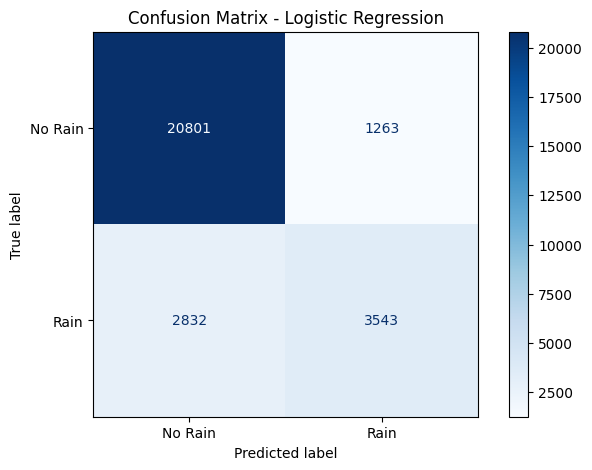

In [34]:
# Detailed Evaluation of Best Model
# =========================

y_pred_best = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=["No Rain", "Rain"]))


cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [35]:
model_filename = "best_rain_model.pkl"
joblib.dump(best_model, model_filename)
print(f"Saved best model ({best_model_name}) to:", model_filename)

Saved best model (Logistic Regression) to: best_rain_model.pkl
